In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
import threading

import time
plt.rcParams["font.family"] = "Times New Roman"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Roundabout\2022-1-19-14-30-0.pcap'
end_frame = 2000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 27.94it/s]


In [3]:
def get_thred(temp,N = 20,d_thred = 0.1,d = 0.3,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        ind = np.abs(temp - sample) < d
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    if len(bck_ds_) < bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-d * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [4]:
def gen_bckmap(aggregated_maps):
    thred_map = np.zeros((3,32,1800))
    with tqdm(total=32*1800) as pbar:
        for i in range(thred_map.shape[1]):
            for j in range(thred_map.shape[2]):
                thred_map[:,i,j] = get_thred(aggregated_map[:,i,j])
#                 print(i,j)
                pbar.update(1)
    return thred_map

In [5]:
a = time.time()
thred_map = gen_bckmap(aggregated_map)
time.time() - a

100%|██████████████████████████████████████████████████████████████████████████| 57600/57600 [00:12<00:00, 4434.76it/s]


12.990261793136597

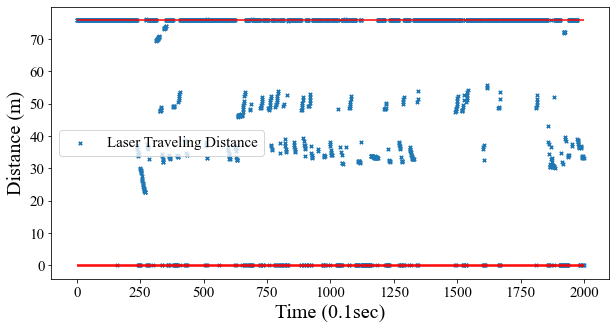

In [31]:
laser_id = 14
azimuth_channel = 51
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
bck_ds = thred_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 12, marker = 'x', label = "Laser Traveling Distance")
for b in bck_ds:
    plt.hlines(b,0,2000, color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)

# plt.ylim(17.5,19)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture5.tif', dpi = 600)
plt.show()

In [7]:
db = Raster_DBSCAN(window_size=[5,15],eps = 1,min_samples= 5,Td_map_szie=(32,1800))

In [19]:
def show_result(Td_map):
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    pcd = get_pcd_colored(Td_map,Labeling_map)
    draw(pcd,width=1000,height=1000)
    return Labeling_map

In [20]:
Td_map = aggregated_map[370].copy()
Labeling_map_0 = show_result(Td_map)
Td_map = aggregated_map[371].copy()
Labeling_map_1 = show_result(Td_map)

WebVisualizer(window_uid='window_11')

WebVisualizer(window_uid='window_12')

In [23]:
Intersect = (Labeling_map_0 != -1) & (Labeling_map_1 != -1)

In [37]:
pairs_intersect,counts_intersect = np.unique(np.array([Labeling_map_0[Intersect],Labeling_map_1[Intersect]]).T,return_counts=True, axis = 0)

In [38]:
unique_label_cur = np.unique(pairs_intersect[:,0])

In [40]:
for l in unique_label_cur:
    union_labels = pairs_union[pairs_union[:,0] == l][:,1]
    dis_cur = Td_map_0[Labeling_map_0 == l].mean()
    valid_labels = []
    for i in union_labels:
        if np.abs(Td_map_0[Labeling_map_0 == i].mean() - dis_cur) < 0.5
            valid_labels.append(i)
    

[0 1]
[2]
[3 5]
[4]
[5]
[6]
[4 7]
[8]
[10]
[10]
[ 9 21]
[12]
[13]
[16]
[ 8 14]
[15]
[17]
[18]
[20]


In [26]:
pairs_union

array([[ 0,  0],
       [ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 2,  5],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  4],
       [ 6,  7],
       [ 7,  8],
       [ 8, 10],
       [ 9, 10],
       [10,  9],
       [10, 21],
       [11, 12],
       [12, 13],
       [13, 16],
       [14,  8],
       [14, 14],
       [15, 15],
       [17, 17],
       [18, 18],
       [20, 20]], dtype=int64)

In [33]:
Td_map = aggregated_map[370].copy()
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored_specified(Td_map,Labeling_map,[6])
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_18')

In [34]:
Td_map = aggregated_map[371].copy()
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored_specified(Td_map,Labeling_map,[4,7])
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_19')

In [31]:
pd.DataFrame(Foreground_map).to_csv(r'D:\Test\Foreg1.csv',index = False)

In [56]:
pd.DataFrame(Labeling_map).to_csv(r'D:\Test\LABEL1.csv',index = False)

In [70]:
unique_labels, counts = np.unique(Labeling_map[Labeling_map != -1],return_counts = True)

In [73]:
erased_label = unique_labels[counts < 10]

In [79]:
for l in erased_label:
    Labeling_map[Labeling_map == l] = -1

In [80]:
Td_map = aggregated_map[380].copy()
# Td_map = medfilt2d(Td_map,kernel_size = 3)
# Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
# Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_25')